In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import polars as pl

# Invisible Influencers – Investigating YouTube’s Bot Phenomenon 

___
### Analysis of the Bot-Like Users
___

#### **Analysis of the Bot-Targeted Channels**

In [13]:
# Load Dataset of Suspicious (Bot-like) Users

df_sus = pl.read_parquet('./data/suspicious_users_2018_metadata.parquet')

df_sus

author,video_id,upload_date,comments,likes,replies,categories,channel_id,dislike_count,duration,like_count,view_count
i64,str,date,u32,i64,i64,str,str,f64,i64,f64,f64
571286317,"""Psuy2CcO5zA""",2018-12-31,22,6,0,"""People & Blogs""","""UCzWmWTPCafQRNl9q9Y53AfQ""",2070.0,384,68947.0,1.840976e6
345657268,"""2S7Yak00e6E""",2018-12-10,9,1274,0,"""People & Blogs""","""UCzWmWTPCafQRNl9q9Y53AfQ""",855.0,311,64364.0,1.433561e6
394100970,"""2S7Yak00e6E""",2018-12-10,9,122,0,"""People & Blogs""","""UCzWmWTPCafQRNl9q9Y53AfQ""",855.0,311,64364.0,1.433561e6
92908462,"""qoqZ9T5O29g""",2018-09-18,25,4,0,"""People & Blogs""","""UCzWmWTPCafQRNl9q9Y53AfQ""",2021.0,427,107645.0,2.081952e6
338214411,"""qoqZ9T5O29g""",2018-09-18,13,14,0,"""People & Blogs""","""UCzWmWTPCafQRNl9q9Y53AfQ""",2021.0,427,107645.0,2.081952e6
…,…,…,…,…,…,…,…,…,…,…,…
150882843,"""8DumVjLgQiM""",2018-08-24,11,4,0,"""News & Politics""","""UCrwE8kVqtIUVUzKui2WVpuQ""",73.0,1552,893.0,27139.0
54116756,"""IZdKtqovYnQ""",2018-08-23,11,26,6,"""News & Politics""","""UCrwE8kVqtIUVUzKui2WVpuQ""",382.0,1137,1290.0,64250.0
288090181,"""IZdKtqovYnQ""",2018-08-23,9,0,0,"""News & Politics""","""UCrwE8kVqtIUVUzKui2WVpuQ""",382.0,1137,1290.0,64250.0


In [14]:
# Compute total number of comments per user

df_sus_comm_per_user = df_sus.select(["author", "comments"]).group_by("author").agg(pl.col("comments").sum()).sort(by="comments", descending=True)

df_sus_comm_per_user

author,comments
i64,u32
309188934,122306
157898414,99550
348995475,93870
137966812,91453
139454261,83153
…,…
329762604,9
49336867,9
55077418,9


- We see that some users commented more than 100k times in 2018.

<div class="alert alert-block alert-info">
Let us analyse the categories of videos targeted by bots, we will weight each category by the number of bot comments it received.
</div>

In [15]:
# Compute the number of comments per category of videos

df_comm_per_cat = df_sus.group_by("categories").agg(pl.col("comments").sum()).sort(by="comments", descending=False)

df_comm_per_cat.head()

categories,comments
str,u32
"""""",165
"""Nonprofits & Activism""",387066
"""Pets & Animals""",901938
"""Travel & Events""",1525025
"""Autos & Vehicles""",2340995


In [16]:
# Get rid of the blank category

df_comm_per_cat = df_comm_per_cat.filter(pl.col("categories")!="").sort(by="comments", descending=True)

df_comm_per_cat.head()

categories,comments
str,u32
"""Entertainment""",16269000
"""Gaming""",14110826
"""People & Blogs""",11966287
"""Howto & Style""",9721603
"""Music""",7292729


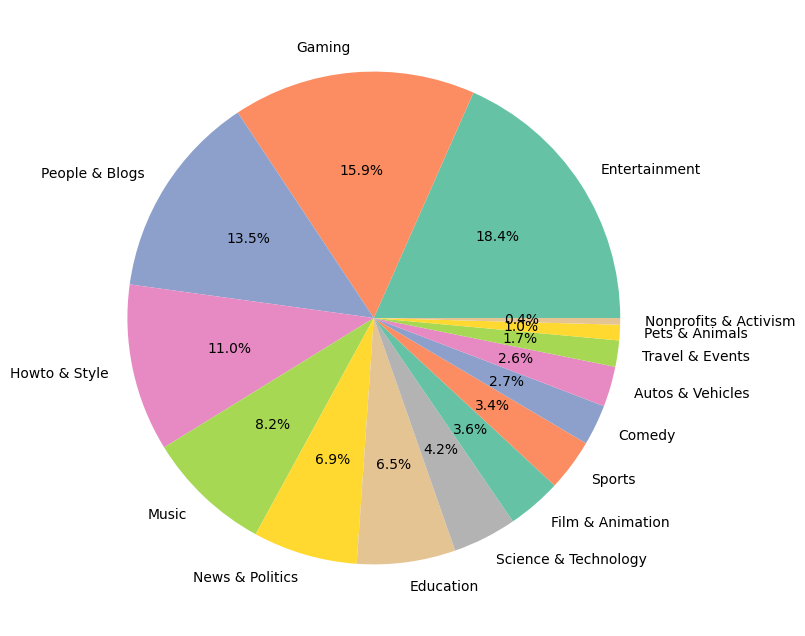

In [17]:
plt.figure(figsize=(12, 8))

plt.pie(x=df_comm_per_cat["comments"], labels=df_comm_per_cat["categories"], autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.show()

<div class="alert alert-block alert-warning">

**Comment**: We need to compare to the initial ditribution of video categories to see if some categories are actually more probable of being targeted by bots, or if it is equiprobable.

In terms of probability, we computed hereabove $P(Category|Bots)$, but we would like to know 'What is the probability of seeing a video of category C being targeted by bots?' i.e. $P(Bots|Category) = \frac{P(Category|Bots)P(Bots)}{P(Category)}$. We can find the other probabilities by going back to the initial dataset and simply counting the number of categories, as well as the number of total comments compared to the bot-like comments.

</div>

**TODO** Compute prior probabilities

#### **Analysis of the Number of Videos Targeted by Bots**

<div class="alert alert-block alert-info">
Let us analyse typically how many videos does one single bot targets. Can we identify different type of behaviours with respect to the number of videos targeted vs the number of comments per video ?
</div>

In [18]:
# Compute number of videos and average number of comments per video for each user

df_videos_per_bot = df_sus.group_by("author").agg(pl.count("author").alias("nb_videos"), pl.col("comments").mean().alias("comments_avg")).sort(by="nb_videos")

df_videos_per_bot.sort(by="nb_videos", descending=True)

author,nb_videos,comments_avg
i64,u32,f64
73662905,1118,19.756708
133567048,937,55.054429
239002533,886,36.553047
379539323,783,43.15198
466126703,763,47.474443
…,…,…
251899283,1,9.0
381705469,1,26.0
252155681,1,9.0


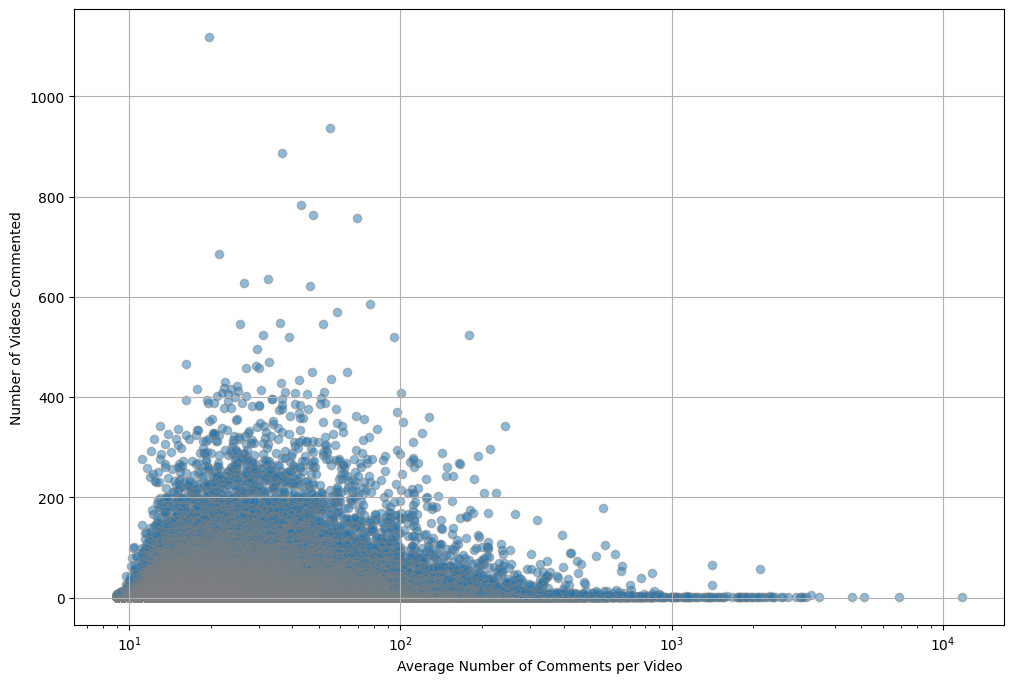

In [19]:
plt.figure(figsize=(12, 8))

plt.scatter(df_videos_per_bot["comments_avg"], df_videos_per_bot["nb_videos"], alpha=0.5, edgecolors='grey')
plt.ylabel('Number of Videos Commented')
plt.xlabel('Average Number of Comments per Video')
plt.xscale('log')
plt.grid(which='major')
plt.show()

<div class="alert alert-block alert-success">

*We observe that the number of comments per video for a bot seems to decrease with the number of videos it comments. Or at least, the variance gets smaller with a higher number of videos and we tend to have less high number of comments per video.*

</div>

<div class="alert alert-block alert-info">
Let us dig to understand who are the bots with a high number of videos commented ?
</div>

In [20]:
# Select bots with more than 200 videos commented

df_high_nb_videos = df_sus.group_by('author').agg(pl.count("author").alias("nb_videos"), pl.col("comments").mean().alias("comments_avg"), pl.count("channel_id").alias("nb_channels"))
df_high_nb_videos

author,nb_videos,comments_avg,nb_channels
i64,u32,f64,u32
410500644,1,10.0,1
520847018,1,10.0,1
87728682,2,9.0,2
431997099,2,10.0,2
343165145,13,16.230769,13
…,…,…,…
208349799,1,11.0,1
88955130,2,11.0,2
484298477,9,16.0,9


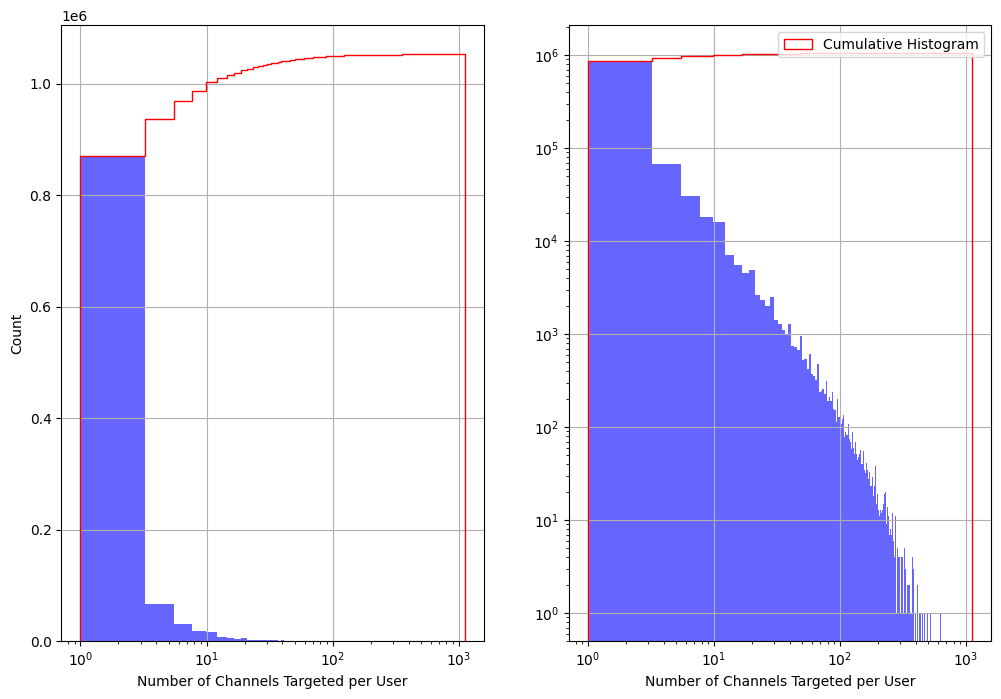

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

n_bins = 500

ax[0].hist(df_high_nb_videos["nb_channels"], bins=n_bins, color='blue', alpha=0.6)
ax[0].hist(df_high_nb_videos["nb_channels"], bins=n_bins, color='red', cumulative=True, histtype='step')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Number of Channels Targeted per User')
ax[0].set_xscale('log')
ax[0].grid()

ax[1].hist(df_high_nb_videos["nb_channels"], bins=n_bins, color='blue', alpha=0.6)
ax[1].hist(df_high_nb_videos["nb_channels"], bins=n_bins, color='red', cumulative=True, histtype='step', label='Cumulative Histogram')
ax[1].set_xlabel('Number of Channels Targeted per User')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].grid()
ax[1].legend(loc='upper right')

plt.show()


In [22]:
df_high_nb_videos['nb_channels'].value_counts(sort=True).with_columns((pl.col('count')/df_high_nb_videos.height).alias('proportion')).head(10)

nb_channels,count,proportion
u32,u32,f64
1,630698,0.599131
2,166488,0.158155
3,73461,0.069784
4,40771,0.03873
5,26238,0.024925
6,17802,0.016911
7,13064,0.01241
8,10020,0.009518
9,8075,0.007671


<div class="alert alert-block alert-success">

*We observe that most of the bot-like users actually do not comment on a lot of different channels. Indeed, for the majority, the bots seem to comment on only a single channel ($\approx$ 60% of the bots).*

*This let us think that since these bots tend to remain on one specific channel, they might be bots associated to channel designed to automatically answer to viewer's comments in order to increase their interactions with their communities.*

</div>